**Brian Blaylock**  
*October 21, 2021*

# Nearest Lat/Lon Points in xarray

It is very handy to pluck points from an xarray dataset that are nearest a latitude/longitude point of interest. One example is comparing station observations to model data at that point.

For some background, read my post on [StakOverflow: xarray select nearest lat/lon with multi-dimension coordinates](https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates). 

My initial implementation was my `pluck_points` function. It finds the nearest grid point to a lat/lon point by finding the absolute minimum value in the point and grid difference.

My new implementation relys on MetPy ability to determine the x and y values based on the map projection. The benefit of this is that it enables us to use xarray's powerful `sel()` method to obtain the points. 

The two methods most often match the same points, but sometimes the matches are slightly different.

This notebook shows a benchmar of the two methods.

In [8]:
# The two methods being tested
from herbie.tools import nearest_points
from toolbox.gridded_data import pluck_points

# Get model data
from herbie.archive import Herbie

# Get point data
from synoptic.services import stations_metadata

# Plotting
import matplotlib.pyplot as plt
from toolbox.cartopy_tools import common_features, pc
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get Model Data
H = Herbie('2021-10-8 12:00', model='HRRR', product='sfc').xarray('TMP:2 m')

🏋🏻‍♂️ Found 2021-Oct-08 12:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
📇 Download subset: [HRRR] model [sfc] product run at 2021-Oct-08 12:00 UTC F00                                                            
 cURL from https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20211008/conus/hrrr.t12z.wrfsfcf00.grib2
   1: GRIB_message=71  TMP:2 m above ground:anl


In [3]:
# Get Point Data
a = stations_metadata(radius='UKBKB,100')
points = np.array(list(zip(a.loc['longitude'], a.loc['latitude'])))
names = a.loc['STID'].to_numpy()

print(f'{len(names):,} stations to match to grid')


 🚚💨 Speedy Delivery from Synoptic API [metadata]: https://api.synopticdata.com/v2/stations/metadata?radius=UKBKB,100&token=🙈HIDDEN

2,587 stations to match to grid


## Match Points
First let's look at the speed for matching just ten points. It doesn't seem the two methods are much different.

In [9]:
%%timeit
ds_nearest = nearest_points(H, points[:10], names[:10])

568 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
ds_pluck = pluck_points(H, points[:10], names[:10])

613 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


but when we try to match more values...the `nearest_points` method works much faster

In [12]:
%%timeit
ds_nearest = nearest_points(H, points[:100], names[:100])

869 ms ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit
ds_pluck = pluck_points(H, points[:100], names[:100])

5.93 s ± 104 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Scalability
Let's graph the time to compute by number of points to match

In [51]:
t_nearest = []
t_pluck = []
n = []

#num = range(1,10,3):
num = [1, 5, 10, 25, 50] + list(range(100,len(names),500))
for i in num[:]:
    timer = datetime.now()
    ds_nearest = nearest_points(H, points[:i], names[:i])
    t_nearest.append((datetime.now()-timer).total_seconds())
    
    timer = datetime.now()
    ds_pluck = pluck_points(H, points[:i], names[:i])
    t_pluck.append((datetime.now()-timer).total_seconds())
    
    n.append(i)

Text(0.5, 0, 'Number of matched points')

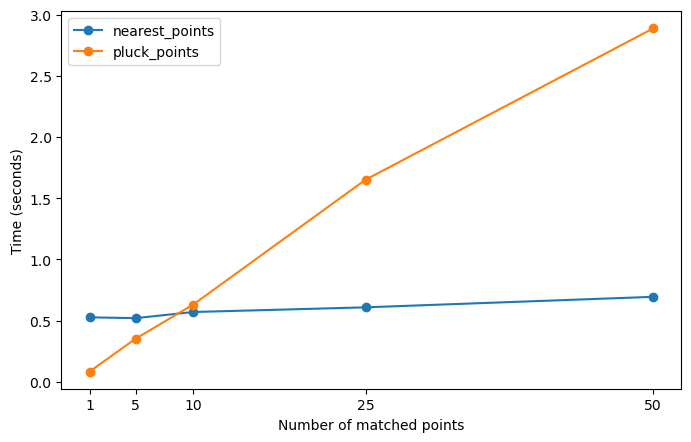

In [54]:
plt.figure(figsize=[8,5], dpi=100)
plt.plot(n[:5], t_nearest[:5], marker='o', label='nearest_points')
plt.plot(n[:5], t_pluck[:5], marker='o', label='pluck_points')
plt.xticks(n[:5])
plt.legend()
plt.ylabel('Time (seconds)')
plt.xlabel('Number of matched points')

Text(0.5, 0, 'Number of matched points')

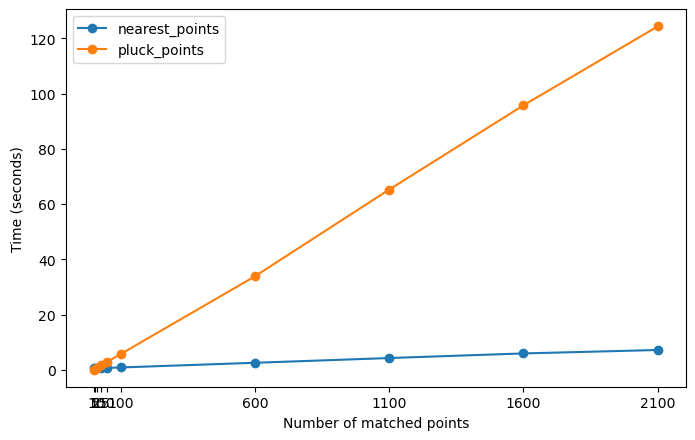

In [52]:
plt.figure(figsize=[8,5], dpi=100)
plt.plot(n, t_nearest, marker='o', label='nearest_points')
plt.plot(n, t_pluck, marker='o', label='pluck_points')
plt.xticks(n)
plt.legend()
plt.ylabel('Time (seconds)')
plt.xlabel('Number of matched points')

**Clearly, the `nearest_points` implementation scales much better.**

I could talk about the implementation of these algorithms with [Big O notation](https://en.wikipedia.org/wiki/Big_O_notation), but I'll save that for the computer scientists. For me, I'm happy just seeing that my new function scales much better.

# Update Stack Overflow Answer
This updated method requires that you know the map projection. If you have a NetCDF file that follows CF convention, you can use MetPy's `parse_cf` method to get the data's coordinate reference system.

In [106]:
import xarray
import metpy
import cartopy.crs as ccrs
from metpy.units import units  # only needed for the example

lats = np.array([[21.138  , 21.14499, 21.15197, 21.15894, 21.16591],
                 [21.16287, 21.16986, 21.17684, 21.18382, 21.19079],
                 [21.18775, 21.19474, 21.20172, 21.2087 , 21.21568],
                 [21.21262, 21.21962, 21.22661, 21.23359, 21.24056],
                 [21.2375 , 21.2445 , 21.25149, 21.25848, 21.26545]])  

lons = np.array([[-122.72   , -122.69333, -122.66666, -122.63999, -122.61331],
                 [-122.7275 , -122.70082, -122.67415, -122.64746, -122.62078],
                 [-122.735  , -122.70832, -122.68163, -122.65494, -122.62825],
                 [-122.7425 , -122.71582, -122.68912, -122.66243, -122.63573],
                 [-122.75001, -122.72332, -122.69662, -122.66992, -122.64321]])

speed = np.array([[10.934007, 10.941321, 10.991583, 11.063932, 11.159435],
                  [10.98778 , 10.975482, 10.990983, 11.042522, 11.131154],
                  [11.013505, 11.001573, 10.997754, 11.03566 , 11.123781],
                  [11.011163, 11.000227, 11.010223, 11.049   , 11.1449  ],
                  [11.015698, 11.026604, 11.030653, 11.076904, 11.201464]])

ds = xarray.Dataset({'SPEED':(('x', 'y'),speed)},
                    coords = {'latitude': (('x', 'y'), lats),
                              'longitude': (('x', 'y'), lons)},
                    attrs={'variable':'Wind Speed'})

In [101]:
ds

<xarray.Dataset>
Dimensions:    (x: 5, y: 5)
Coordinates:
    latitude   (x, y) float64 21.14 21.14 21.15 21.16 ... 21.25 21.26 21.27
    longitude  (x, y) float64 -122.7 -122.7 -122.7 ... -122.7 -122.7 -122.6
Dimensions without coordinates: x, y
Data variables:
    SPEED      (x, y) float64 10.93 10.94 10.99 11.06 ... 11.03 11.03 11.08 11.2
Attributes:
    variable:  Wind Speed

In [102]:
# For the purpose of the minimal example in the question,
# I happen to know that these lat/lons came from the HRRR model
# and I'll add the corresponding CF data.

cf_attrs = {
     'semi_major_axis': 6371229.0,
     'semi_minor_axis': 6371229.0,
     'inverse_flattening': 0.0,
     'reference_ellipsoid_name': 'unknown',
     'longitude_of_prime_meridian': 0.0,
     'prime_meridian_name': 'Greenwich',
     'geographic_crs_name': 'unknown',
     'horizontal_datum_name': 'unknown',
     'projected_crs_name': 'unknown',
     'grid_mapping_name': 'lambert_conformal_conic',
     'standard_parallel': (38.5, 38.5),
     'latitude_of_projection_origin': 38.5,
     'longitude_of_central_meridian': 262.5,
     'false_easting': 0.0,
     'false_northing': 0.0,
     'long_name': 'HRRR model grid projection'
}

ds = ds.metpy.assign_crs(cf_attrs)
ds

# Alternatively, you can use the `parse_cf` method if your Dataset already
# has the CF convention data.
#ds.metpy.parse_cf()

<xarray.Dataset>
Dimensions:    (x: 5, y: 5)
Coordinates:
    latitude   (x, y) float64 21.14 21.14 21.15 21.16 ... 21.25 21.26 21.27
    longitude  (x, y) float64 -122.7 -122.7 -122.7 ... -122.7 -122.7 -122.6
    metpy_crs  object Projection: lambert_conformal_conic
Dimensions without coordinates: x, y
Data variables:
    SPEED      (x, y) float64 10.93 10.94 10.99 11.06 ... 11.03 11.03 11.08 11.2
Attributes:
    variable:  Wind Speed

In [104]:
# Now we need to convert the x and y index to map projection values
# This is also done with the MetPy accessor
# (I only specify the tolerance to be much higher because the 
# example data is truncated; this is not needed if the lat/lon data
# were not truncated)
ds_new = ds.metpy.assign_y_x(tolerance=13*units.km)

In [105]:
ds_new

<xarray.Dataset>
Dimensions:    (x: 5, y: 5)
Coordinates:
    latitude   (x, y) float64 21.14 21.14 21.15 21.16 ... 21.25 21.26 21.27
    longitude  (x, y) float64 -122.7 -122.7 -122.7 ... -122.7 -122.7 -122.6
    metpy_crs  object Projection: lambert_conformal_conic
  * y          (y) float64 -1.581e+06 -1.581e+06 ... -1.581e+06 -1.581e+06
  * x          (x) float64 -2.692e+06 -2.692e+06 ... -2.692e+06 -2.692e+06
Data variables:
    SPEED      (x, y) float64 10.93 10.94 10.99 11.06 ... 11.03 11.03 11.08 11.2
Attributes:
    variable:  Wind Speed

In [107]:
# Convert lat/lon points you want to match to the data's coordindate reference system (crs).
# This is done with cartopy
crs = ds_new.metpy_crs.item().to_cartopy()
crs

In [139]:
# I want to find the speed at a certain lat/lon point.
lat = 21.22
lon = -122.68

points = np.array([(lat, lon)])#, (21.20, -122.68)])

In [140]:
lats = points[:,0]
lons = points[:,1]
transformed_data = crs.transform_points(ccrs.PlateCarree(), lons, lats)
xs = transformed_data[:,0]
ys = transformed_data[:,1]

In [141]:
# And these are the index we wish to find, in map coordinates
xs, ys

(array([-2690829.91468918]), array([-1579311.19797689]))

In [144]:
ds_new.sel(x=xs[0], method='nearest')

ValueError: index must be monotonic increasing or decreasing

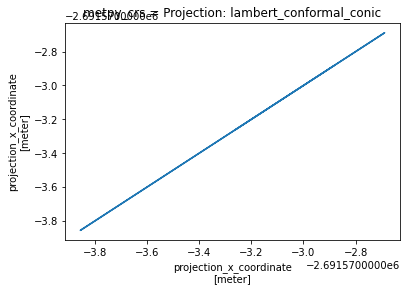

In [147]:
ds_new.x.plot()

In [118]:
ccrs.PlateCarree().transform_points(crs, ds_new.x.data, ds_new.y.data)

array([[-122.68163088,   21.20172966,    0.        ],
       [-122.68163877,   21.2017249 ,    0.        ],
       [-122.68163   ,   21.20172   ,    0.        ],
       [-122.68162664,   21.2017218 ,    0.        ],
       [-122.68163425,   21.20172883,    0.        ]])